# 1. Setup

## 1.1: Importazione delle librerie necessarie

In [1]:
# Importiamo le librerie fondamentali
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import warnings
from scipy.stats import pearsonr
from statsmodels.tsa.arima_process import ArmaProcess
import itertools

In [2]:
warnings.simplefilter(action='ignore', category=FutureWarning)

# Sopprimi i RuntimeWarning
warnings.filterwarnings("ignore", category=RuntimeWarning)

In [3]:
# pd.set_option('display.width', 200) # Imposta una larghezza adeguata per evitare a capo

In [4]:
# Fissiamo un seme per la riproducibilità
np.random.seed(42)

## 1.2: Lettura dati

In [5]:
dati = pd.read_csv('Bitcoin (€) da yfinance dal 17-09-2014 al 24-04-2024.csv')
dati = dati[['Date', 'Close']]
dati = dati.rename(columns = {'Date':'Timestamp', 'Close': 'Price'})
dati['Timestamp'] = pd.to_datetime(dati['Timestamp'])
dati['Timestamp'] = dati['Timestamp'].dt.strftime('%Y-%m-%d')
dati['Timestamp'] = pd.to_datetime(dati['Timestamp'], format='%Y-%m-%d')
dati

,Timestamp,Price
0,2014-09-17,355.957367
1,2014-09-18,328.539368
2,2014-09-19,307.761139
3,2014-09-20,318.758972
4,2014-09-21,310.632446
...,...,...
3503,2024-04-20,59876.710938
3504,2024-04-21,60956.074219
3505,2024-04-22,60919.242188
3506,2024-04-23,62729.296875


In [6]:
data_inizio = '2014-09-17'
data_fine = '2024-04-24'
indice_inizio = dati[dati['Timestamp'] == data_inizio].index[0]
indice_fine = dati[dati['Timestamp'] == data_fine].index[0]
dati = dati[indice_inizio:indice_fine + 1].reset_index(drop=True)
dati

,Timestamp,Price
0,2014-09-17,355.957367
1,2014-09-18,328.539368
2,2014-09-19,307.761139
3,2014-09-20,318.758972
4,2014-09-21,310.632446
...,...,...
3503,2024-04-20,59876.710938
3504,2024-04-21,60956.074219
3505,2024-04-22,60919.242188
3506,2024-04-23,62729.296875


# 2. Generazione dei dataset con bullishness e volatilità specifiche

In [7]:
# def calcola_distribuzione_variazioni(dati, n_bins):
#     variazioni = dati['Price'].pct_change().dropna().reset_index(drop=True)
#     distribuzione_variazioni = {}
#     bins = np.linspace(np.min(variazioni), np.max(variazioni), n_bins + 1)
    
#     for i in range(n_bins):
#         bin_min = bins[i]
#         bin_max = bins[i + 1]
#         if i < n_bins - 1:
#             variazioni_bin = variazioni[(variazioni >= bin_min) & (variazioni < bin_max)]
#         else:
#             variazioni_bin = variazioni[(variazioni >= bin_min) & (variazioni <= bin_max)]
        
#         mean_value = np.mean(variazioni_bin)
#         prob_value = len(variazioni_bin) / len(variazioni)
        
#         if not np.isnan(mean_value):
#             distribuzione_variazioni[f"[{bin_min:.4f}, {bin_max:.4f}]"] = (mean_value, prob_value)
    
#     return distribuzione_variazioni

In [8]:
# # Funzione per generare un dataset sintetico con una bullishness target
# def genera_dataset_bullishness(L, punteggio_target, distribuzione_variazioni_positive, distribuzione_variazioni_negative):
#     prezzi = [100]  # Prezzo iniziale
#     for _ in range(L - 1):
#         if np.random.rand() < (punteggio_target + 1) / 2:  # Converto bullishness da [-1, 1] a [0, 1]
#             variazioni = [valore[0] for valore in distribuzione_variazioni_positive.values()]
#             probabilita = [valore[1] for valore in distribuzione_variazioni_positive.values()]
#         else:
#             variazioni = [valore[0] for valore in distribuzione_variazioni_negative.values()]
#             probabilita = [valore[1] for valore in distribuzione_variazioni_negative.values()]
        
#         probabilita = probabilita / np.sum(probabilita)
#         variazione = np.random.choice(variazioni, p=probabilita)
#         prezzi.append(prezzi[-1] * (1 + variazione))
    
#     return prezzi

In [9]:
# # Funzione per calcolare l'autocorrelazione di un dataset
# # def calculate_autocorrelation(prices, lag=1):
# #     returns = np.diff(prices) / prices[:-1]
# #     return pd.Series(returns).autocorr(lag=lag)

# def calculate_autocorrelation(prices):
#     return np.corrcoef(prices[:-1], prices[1:])[0, 1]

# # # Funzione per generare un dataset con autocorrelazione desiderata usando un processo AR(1)
# # def genera_dataset_autocorrelato(n, target_autocorrelazione, delta_3, min_price, media_rumore, sigma_rumore, prezzo_iniziale=100, lag=1):
# #     """
# #     Genera un dataset sintetico con autocorrelazione target entro una tolleranza delta_3.
# #     """
# #     while True:
# #         # Generazione della serie con autocorrelazione target
# #         phi = target_autocorrelazione
# #         epsilon = np.random.normal(media_rumore, sigma_rumore, n)
# #         prezzi = [prezzo_iniziale]
        
# #         for t in range(1, n):
# #             x_t = phi * prezzi[t-1] + epsilon[t]
# #             prezzi.append(x_t)
        
# #         prezzi = np.array(prezzi)
    
# #         # Traslazione per assicurare la positività
# #         min_valore = np.min(prezzi)
# #         if min_valore < 0:
# #             prezzi += abs(min_valore) + min_price  # Aggiungi min_price per mantenere il minimo >= min_price

# #         # Calcolo dell'autocorrelazione attuale della serie generata
# #         autocorrelazione_attuale = calculate_autocorrelation(prezzi, lag)
        
# #         # Verifica se l'autocorrelazione è entro il range accettabile
# #         if abs(autocorrelazione_attuale - target_autocorrelazione) <= delta_3:
# #             break
    
# #     return prezzi

# # Funzione per generare un dataset con autocorrelazione desiderata usando un processo AR(1)
# # def genera_dataset_autocorrelato(n, target_autocorrelazione, delta_3, min_price, mu, sigma, prezzo_iniziale=100, lag=1):
# #     """
# #     Genera un dataset sintetico con autocorrelazione target entro una tolleranza delta_3,
# #     utilizzando un processo AR(1) con parametri adattati per mantenere media e varianza desiderate.
# #     """
# #     phi = target_autocorrelazione
    
# #     # Calcolo dell'offset `c` e della deviazione standard del rumore `sigma_e`
# #     c = mu * (1 - phi)
# #     sigma_e = sigma * np.sqrt(1 - phi ** 2)
    
# #     while True:
# #         # Generazione della serie con autocorrelazione target
# #         prezzi = [prezzo_iniziale]
        
# #         for t in range(1, n):
# #             # Applicazione del modello AR(1)
# #             x_t = c + phi * prezzi[t - 1] + np.random.normal(0, sigma_e)
# #             prezzi.append(x_t)
        
# #         prezzi = np.array(prezzi)
        
# #         # Traslazione per assicurare la positività
# #         min_valore = np.min(prezzi)
# #         if min_valore < 0:
# #             prezzi += abs(min_valore) + min_price  # Aggiungi min_price per mantenere il minimo >= min_price

# #         # Calcolo dell'autocorrelazione attuale della serie generata
# #         autocorrelazione_attuale = calculate_autocorrelation(prezzi, lag)
        
# #         # Verifica se l'autocorrelazione è entro il range accettabile
# #         if abs(autocorrelazione_attuale - target_autocorrelazione) <= delta_3:
# #             break
    
# #     return prezzi

# # Funzione per generare un dataset con autocorrelazione desiderata usando un processo AR(1)
# def genera_dataset_autocorrelato(n, target_autocorrelazione, delta_3, mu, sigma, min_price, noise_seed):
#     """
#     Genera un dataset sintetico con autocorrelazione target rispetto a lag=1 entro una tolleranza delta_3,
#     utilizzando un processo AR(1) e garantendo media e deviazione standard desiderate.
    
#     Parametri:
#     - n: numero di campioni
#     - target_autocorrelazione: valore di autocorrelazione desiderato per lag=1
#     - delta_3: tolleranza per l'autocorrelazione
#     - min_price: valore minimo per traslare i prezzi in positivo
#     - mu: media target del processo
#     - sigma: deviazione standard target del processo
#     - prezzo_iniziale: valore iniziale del prezzo
#     - seed: seme per generazione casuale (riproducibilità)
    
#     Ritorna:
#     - Un array numpy contenente il dataset generato
#     """

#     np.random.seed(noise_seed)  # Cambia seme solo per il rumore

#     # Definisci il parametro phi per il processo AR(1)
#     phi = target_autocorrelazione
    
#     # Calcola l'offset `c` e la deviazione standard del rumore `sigma_e`
#     c = mu * (1 - phi)
#     sigma_e = sigma * np.sqrt(1 - phi ** 2)
    
#     # Definisci il processo AR(1) utilizzando ArmaProcess
#     ar = np.array([1, -phi])  # Nota: statsmodels richiede segno negativo per `phi`
#     ma = np.array([1])  # Nessuna componente MA
#     arma_process = ArmaProcess(ar, ma)
    
#     # Genera campioni fino a ottenere autocorrelazione target entro delta_3
#     while True:
#         prezzi = arma_process.generate_sample(nsample=n, scale=sigma_e) + c
        
#         # Traslazione per garantire la positività
#         min_valore = np.min(prezzi)
#         if min_valore < 0:
#             prezzi += abs(min_valore) + min_price
        
#         # Calcola autocorrelazione a lag=1
#         autocorrelazione_attuale = calculate_autocorrelation(prezzi)
        
#         # Se entro la tolleranza richiesta, interrompe il ciclo
#         if abs(autocorrelazione_attuale - target_autocorrelazione) <= delta_3:
#             break
    
#     return prezzi

# # Funzione per calcolare bullishness di un dataset
# def calculate_bullishness(prices):
#     differenze_prezzo = np.diff(prices)
#     bullishness = 2 * (np.sum(differenze_prezzo[differenze_prezzo > 0]) / np.sum(np.abs(differenze_prezzo))) - 1
#     return bullishness

# # Funzione per calcolare la volatilità di un dataset
# def calculate_volatility(prices):
#     variazioni = np.diff(prices) / prices[:-1]
#     return np.std(np.abs(variazioni))

# # Funzione per aggiustare la bullishness cercando di mantenere l'autocorrelazione invariata
# def imponi_dataset_bullishness(prices, target_bullishness, delta_1):
#     current_bullishness = calculate_bullishness(prices)
    
#     if abs(current_bullishness - target_bullishness) <= delta_1:
#         return prices  # Se la bullishness è già nel range, non fare nulla
    
#     # Correzione: aggiusta i prezzi per favorire la bullishness target
#     for i in range(len(prices)):
#         if current_bullishness < target_bullishness:
#             prices[i] *= 1.01  # Aumenta leggermente i prezzi per favorire bullishness positiva
#         elif current_bullishness > target_bullishness:
#             prices[i] *= 0.99  # Riduci leggermente i prezzi per favorire una bullishness più neutrale

#         # Ricalcola la bullishness dopo la correzione
#         current_bullishness = calculate_bullishness(prices)
#         if abs(current_bullishness - target_bullishness) <= delta_1:
#             break  # Bullishness soddisfatta

#     return prices

# # Funzione per correggere la volatilità solo se necessario, mantenendo autocorrelazione e bullishness
# def correggi_volatilita(prices, target_volatilita, delta_2):
#     current_volatility = calculate_volatility(prices)
    
#     if abs(current_volatility - target_volatilita) <= delta_2:
#         return prices  # Se la volatilità è già dentro l'intervallo, non fare nulla

#     # Correzione: modifica leggera delle variazioni
#     variazioni = np.diff(prices) / prices[:-1]
#     std_attuale = np.std(np.abs(variazioni))
    
#     # Generiamo fattori in un range vicino alla volatilità target
#     fattori = np.linspace((target_volatilita - delta_2) / std_attuale, 
#                           (target_volatilita + delta_2) / std_attuale, 100)
    
#     for fattore in fattori:
#         nuove_variazioni = variazioni * fattore
#         nuova_volatilita = np.std(np.abs(nuove_variazioni))
        
#         if abs(nuova_volatilita - target_volatilita) <= delta_2:
#             prezzi_corr = [prices[0]]
#             for var in nuove_variazioni:
#                 prezzi_corr.append(prezzi_corr[-1] * (1 + var))
#             return prezzi_corr

#     # Metodo tradizionale se nessun fattore ha funzionato
#     fattore = target_volatilita / std_attuale
#     nuove_variazioni = variazioni * fattore
#     prezzi_corr = [prices[0]]
#     for var in nuove_variazioni:
#         prezzi_corr.append(prezzi_corr[-1] * (1 + var))
    
#     return prezzi_corr

In [10]:
# calculate_autocorrelation((genera_dataset_autocorrelato(60, 0.991, delta_3=0.001, mu=0, sigma=1, min_price=10, noise_seed = 42)))

In [11]:
# # Funzione per generare dataset sintetico completo con tutte le feature target
# def genera_dataset_sintetico_completo(L, target_bullishness, target_volatilita, target_autocorrelazione, delta_1, delta_2, delta_3, sigma_rumore, media_rumore, dataset_index, n_datasets, min_price, specific_seed):
#     numero_tentativi = 0
    
#     while True:
#         numero_tentativi += 1

#         # Generazione di un nuovo seme specifico per il rumore
#         noise_seed = specific_seed + numero_tentativi
#         prezzi = genera_dataset_autocorrelato(L, target_autocorrelazione, delta_3=delta_3, mu=media_rumore, sigma=sigma_rumore, min_price=min_price, noise_seed=noise_seed)
        
#         # # Step 1: Genera un dataset sintetico con l'autocorrelazione target
#         # prezzi = genera_dataset_autocorrelato(L, target_autocorrelazione, delta_3=delta_3, mu = media_rumore, sigma=sigma_rumore, min_price=min_price, seed=specific_seed)
        
#         # Step 2: Correggi la bullishness se necessario
#         prezzi = imponi_dataset_bullishness(prezzi, target_bullishness, delta_1)
        
#         # Step 3: Correggi la volatilità se necessario
#         prezzi = correggi_volatilita(prezzi, target_volatilita, delta_2)
        
#         # Step 4: Verifica tutte le feature
#         bullishness_attuale = calculate_bullishness(prezzi)
#         volatilita_attuale = calculate_volatility(prezzi)
#         autocorrelazione_attuale = calculate_autocorrelation(prezzi)

#         # Stampa il progresso e il numero di tentativi
#         print(f"Generando dataset {dataset_index}/{n_datasets}, tentativo {numero_tentativi}...")
#         print(f"Bullishness attuale: {bullishness_attuale:.5f}, Volatilità attuale: {volatilita_attuale:.5f}, Autocorrelazione attuale: {autocorrelazione_attuale:.5f}")
        
#         # Controlla se tutte le feature sono soddisfatte entro i margini di errore
#         if abs(bullishness_attuale - target_bullishness) <= delta_1 and \
#            abs(volatilita_attuale - target_volatilita) <= delta_2 and \
#            abs(autocorrelazione_attuale - target_autocorrelazione) <= delta_3:
#             print(f"Dataset {dataset_index}/{n_datasets} generato con successo in {numero_tentativi} tentativi!\n")
#             return prezzi, numero_tentativi
        
#         # Se una feature non è soddisfatta, la correggiamo e ricominciamo il ciclo
#         if abs(bullishness_attuale - target_bullishness) > delta_1:
#             prezzi = imponi_dataset_bullishness(prezzi, target_bullishness, delta_1)
#         if abs(volatilita_attuale - target_volatilita) > delta_2:
#             prezzi = correggi_volatilita(prezzi, target_volatilita, delta_2)
#         if abs(autocorrelazione_attuale - target_autocorrelazione) > delta_3:
#             print("Autocorrelazione fuori dal range: rigenerazione del dataset...\n")
#             continue  # Ritorna all'inizio del ciclo per generare un nuovo dataset con autocorrelazione corretta

In [12]:
# # Parametri di configurazione
# n_datasets = 50  # Numero di dataset sintetici da generare
# L = 60  # Durata del dataset in giorni
# # n_bins = 50  # Numero di bin per la distribuzione delle variazioni

# target_bullishness = 0.95  # Bullishness target (punteggio tra -1 e 1)
# target_volatilita = 0.5  # Volatilità target
# target_autocorrelazione = 0.99  # Autocorrelazione target
# delta_1 = 999  # Errore massimo accettato per bullishness
# delta_2 = 999  # Errore massimo accettato per volatilità
# delta_3 = 0.001  # Errore massimo accettato per autocorrelazione
# prezzo_iniziale = 100
# sigma_rumore =  (1 - abs(target_autocorrelazione))
# media_rumore = 20
# min_price = 10

# # Calcoliamo le distribuzioni positive e negative
# # distribuzione_variazioni = calcola_distribuzione_variazioni(dati, n_bins)
# # distribuzione_variazioni_positive = {k: v for k, v in distribuzione_variazioni.items() if v[0] > 0}
# # distribuzione_variazioni_negative = {k: v for k, v in distribuzione_variazioni.items() if v[0] < 0}

# # Genera n_datasets dataset sintetici
# datasets_sintetici = []
# numero_tentativi_totale = 0  # Contatore tentativi

# for i in range(1, n_datasets + 1):
#     print(f"Generazione dataset {i}/{n_datasets}...")

#     # Genera un nuovo seme per ogni dataset basato sul seme globale
#     specific_seed = np.random.randint(0, 2**31 - 1)  # Genera un seme unico
#     np.random.seed(specific_seed)  # Imposta il nuovo seme per questa iterazione

#     # Genera il dataset con la bullishness, volatilità e autocorrelazione richieste
#     prezzi, numero_tentativi = genera_dataset_sintetico_completo(
#         L, target_bullishness, target_volatilita, target_autocorrelazione, delta_1, delta_2, delta_3, sigma_rumore, media_rumore, i, n_datasets, min_price, specific_seed
#     )
#     numero_tentativi_totale += numero_tentativi

#     # Creiamo un DataFrame con Timestamp e Price
#     dataset_df = pd.DataFrame({
#         "Timestamp": pd.date_range(start='2000-01-01', periods=L),
#         "Price": prezzi
#     })
#     datasets_sintetici.append(dataset_df)

# # Stampa il numero totale di tentativi per creare i dataset
# print('Numero totale di tentativi per creare i dataset:', numero_tentativi_totale)

# # Visualizza il grafico del primo dataset sintetico
# plt.plot(datasets_sintetici[0]["Timestamp"], datasets_sintetici[0]["Price"])
# plt.title(f'Primo dataset sintetico con bullishness={target_bullishness}, volatilità={target_volatilita} e autocorrelazione={target_autocorrelazione}')
# plt.xlabel('Data')
# plt.ylabel('Prezzo')
# plt.grid(True)
# plt.show()

In [13]:
# datasets_sintetici[0]

In [14]:
# # Verifica delle deviazioni standard per ciascun dataset sintetico
# for i, dataset in enumerate(datasets_sintetici):
#     # Estrae i prezzi dal DataFrame
#     prezzi = dataset["Price"].values
    
#     # Calcola le variazioni percentuali giornaliere
#     variazioni = np.diff(prezzi) / prezzi[:-1]
    
#     # Calcola la volatilità (deviazione standard dei moduli delle variazioni percentuali)
#     volatilita_attuale = np.std(np.abs(variazioni))
    
#     # Stampa la volatilità attuale e la differenza dal target
#     print(f'Dataset {i+1}: Volatilità = {volatilita_attuale:.5f}, Differenza dal target = {abs(volatilita_attuale - target_volatilita):.5f}')
    
#     # Controlla se la volatilità è fuori dal range consentito
#     if abs(volatilita_attuale - target_volatilita) > delta_2:
#         print(f'Attenzione: La volatilità del dataset {i+1} è fuori dal range consentito!\n')

# 2.1. Metodo alternativo per generare dataset con certi target di bullishness, volatilità e autocorrelazione
Anzichè cercare di creare dataset sintetici con certi target di bullishness, volatilità dei moduli delle variazioni giornaliere e autocorrelazione dei prezzi con lag=1 (cosa difficile da fare perchè ci sono delle relazioni intrinseche tra questi target che non sono ben chiare), genero tantissimi dataset con una certa autocorrelazione e solo dopo clusterizzo per vedere quali valori di bullishness e volatilità posso ottenere dal target di autocorrelazione scelto

In [15]:
def calculate_autocorrelation(prices):
    return np.corrcoef(prices[:-1], prices[1:])[0, 1]

# Funzione per generare un dataset con autocorrelazione desiderata usando un processo AR(1)
def genera_dataset_autocorrelato(n, target_autocorrelazione, delta_3, mu, sigma, min_price, noise_seed):
    """
    Genera un dataset sintetico con autocorrelazione target rispetto a lag=1 entro una tolleranza delta_3,
    utilizzando un processo AR(1) e garantendo media e deviazione standard desiderate.
    """
    np.random.seed(noise_seed)  # Cambia seme solo per il rumore

    phi = target_autocorrelazione
    c = mu * (1 - phi)
    sigma_e = sigma * np.sqrt(1 - phi ** 2)

    ar = np.array([1, -phi])
    ma = np.array([1])
    arma_process = ArmaProcess(ar, ma)

    # Genera campioni fino a ottenere autocorrelazione target entro delta_3
    while True:
        prezzi = arma_process.generate_sample(nsample=n, scale=sigma_e) + c

        # Traslazione per garantire la positività
        min_valore = np.min(prezzi)
        if min_valore < 0:
            prezzi += abs(min_valore) + min_price

        # Calcola autocorrelazione a lag=1
        autocorrelazione_attuale = calculate_autocorrelation(prezzi)

        if abs(autocorrelazione_attuale - target_autocorrelazione) <= delta_3:
            break

    return prezzi

# Funzioni per calcolare bullishness, volatilità e autocorrelazione
def calculate_bullishness(prices):
    differenze_prezzo = np.diff(prices)
    bullishness = 2 * (np.sum(differenze_prezzo[differenze_prezzo > 0]) / np.sum(np.abs(differenze_prezzo))) - 1
    return bullishness

def calculate_volatility(prices):
    variazioni = np.diff(prices) / prices[:-1]
    return np.std(np.abs(variazioni))

# Funzione per generare e clusterizzare dataset sintetici
def genera_e_clusterizza_datasets(n_datasets, L, target_autocorrelazione, delta_3, min_price, mu, sigma, verbose, plotta_primo_dataset, bullishness_bins_step, volatility_bins_step):
    datasets = []
    seeds = np.random.randint(0, 2**31 - 1, size=n_datasets)
    for i, seed in enumerate(seeds):
        tentativi = 0
        while True:
            tentativi += 1
            if verbose:
                print(f" Generando dataset {i + 1}, tentativo {tentativi}...")

            prezzi = genera_dataset_autocorrelato(L, target_autocorrelazione, delta_3, mu, sigma, min_price, noise_seed=seed)
            autocorrelazione_attuale = calculate_autocorrelation(prezzi)
            if abs(autocorrelazione_attuale - target_autocorrelazione) <= delta_3:
                break

        bullishness = calculate_bullishness(prezzi)
        volatility = calculate_volatility(prezzi)
        datasets.append({
            "Price": prezzi,
            "Bullishness": bullishness,
            "Volatility": volatility,
            "Autocorrelation": autocorrelazione_attuale
        })
        if verbose:
            print(f"Dataset {i + 1}/{n_datasets} generato con Bullishness={bullishness:.5f}, Volatilità={volatility:.5f}, Autocorrelazione={autocorrelazione_attuale:.5f}")

    df = pd.DataFrame(datasets)
    bullishness_bins = np.arange(-1, 1 + bullishness_bins_step, bullishness_bins_step)
    max_volatility = df["Volatility"].max()
    volatility_bins = np.arange(0, max_volatility + volatility_bins_step, volatility_bins_step)
    df["Bullishness_Cluster"] = pd.cut(df["Bullishness"], bins=bullishness_bins)
    df["Volatility_Cluster"] = pd.cut(df["Volatility"], bins=volatility_bins)
    cluster_stats = df.groupby(["Bullishness_Cluster", "Volatility_Cluster"]).agg(
        Count=('Price', 'size'),
        Avg_Bullishness=('Bullishness', 'mean'),
        Std_Bullishness=('Bullishness', 'std'),
        Avg_Volatility=('Volatility', 'mean'),
        Std_Volatility=('Volatility', 'std'),
        Avg_Autocorrelation=('Autocorrelation', 'mean'),
        Std_Autocorrelation=('Autocorrelation', 'std')
    ).dropna().reset_index()

    if plotta_primo_dataset:
        plt.plot(datasets[0]["Price"])
        plt.title(f'Primo Dataset con Autocorrelazione target={target_autocorrelazione}, Bullishness={datasets[0]["Bullishness"]:.5f}, Volatilità={datasets[0]["Volatility"]:.5f}')
        plt.xlabel('Tempo')
        plt.ylabel('Prezzo')
        plt.grid(True)
        plt.show()

    return cluster_stats, df

In [16]:
# Parametri di configurazione
n_datasets = 50000  # Numero di dataset da generare
L = 60  # Lunghezza di ogni dataset
target_autocorrelation = 0.9  # Autocorrelazione target
delta_3 = 0.05  # Margine per l'autocorrelazione
min_price = 10  # Minimo prezzo per evitare valori negativi
media_rumore_autocorrelazione = -4  # Media per la gaussiana che rappresenta il rumore
sigma_rumore_autocorrelazione = 3  # Deviazione standard fissa per il processo
verbose = False
plotta_primo_dataset = False
bullishness_bins_step = 0.01
volatility_bins_step = 0.01

# Genera e clusterizza i dataset
cluster_stats, df = genera_e_clusterizza_datasets(n_datasets, L, target_autocorrelation, delta_3, min_price, media_rumore_autocorrelazione, sigma_rumore_autocorrelazione, verbose, plotta_primo_dataset, bullishness_bins_step, volatility_bins_step)

# Stampa le statistiche di ciascun cluster
print("\nStatistiche dei Cluster senza le righe con NaN:")
cluster_stats


Statistiche dei Cluster senza le righe con NaN:


,Bullishness_Cluster,Volatility_Cluster,Count,Avg_Bullishness,Std_Bullishness,Avg_Volatility,Std_Volatility,Avg_Autocorrelation,Std_Autocorrelation
0,"(-0.22, -0.21]","(0.04, 0.05]",2,-0.210469,0.000166,0.040107,0.000140,0.931325,0.013879
1,"(-0.21, -0.2]","(0.03, 0.04]",2,-0.204817,0.005551,0.037720,0.003174,0.939019,0.007345
2,"(-0.21, -0.2]","(0.04, 0.05]",2,-0.201798,0.001566,0.047162,0.000320,0.939713,0.003204
3,"(-0.2, -0.19]","(0.04, 0.05]",6,-0.195341,0.003022,0.043808,0.002233,0.917229,0.011814
4,"(-0.2, -0.19]","(0.05, 0.06]",2,-0.194339,0.003818,0.050638,0.000448,0.912818,0.004333
...,...,...,...,...,...,...,...,...,...
181,"(0.18, 0.19]","(0.06, 0.07]",5,0.184572,0.002344,0.061801,0.000987,0.907547,0.025222
182,"(0.19, 0.2]","(0.04, 0.05]",3,0.191316,0.000408,0.046965,0.003270,0.922468,0.009363
183,"(0.19, 0.2]","(0.05, 0.06]",4,0.193062,0.000587,0.052436,0.001546,0.890029,0.034853
184,"(0.2, 0.21]","(0.04, 0.05]",3,0.202451,0.001661,0.047074,0.002359,0.921179,0.026608


In [17]:
df

,Price,Bullishness,Volatility,Autocorrelation,Bullishness_Cluster,Volatility_Cluster
0,"[19.7712222239885, 19.384910793847997, 18.9969...",-0.037770,0.063785,0.864818,"(-0.04, -0.03]","(0.06, 0.07]"
1,"[16.874621449933098, 15.857582489506914, 15.50...",-0.076460,0.050914,0.880432,"(-0.08, -0.07]","(0.05, 0.06]"
2,"[16.085893189101565, 15.92473468579208, 15.422...",0.021523,0.051648,0.896364,"(0.02, 0.03]","(0.05, 0.06]"
3,"[17.442846604130644, 17.195962063988443, 16.90...",-0.034933,0.053166,0.851171,"(-0.04, -0.03]","(0.05, 0.06]"
4,"[15.018129601948297, 15.248199977335153, 14.20...",-0.043783,0.043697,0.913753,"(-0.05, -0.04]","(0.04, 0.05]"
...,...,...,...,...,...,...
49995,"[17.159424685840644, 17.204193779289575, 17.00...",0.017713,0.054169,0.859582,"(0.01, 0.02]","(0.05, 0.06]"
49996,"[11.601015643736048, 14.576517543854287, 14.28...",0.067085,0.057582,0.877667,"(0.06, 0.07]","(0.05, 0.06]"
49997,"[14.053172946915687, 14.385200243298971, 13.36...",0.066061,0.054592,0.859682,"(0.06, 0.07]","(0.05, 0.06]"
49998,"[15.129372382751884, 18.160483038694668, 18.60...",-0.033887,0.052678,0.853836,"(-0.04, -0.03]","(0.05, 0.06]"


## 2.1.1 Ciclo per generare tanti dataset per ogni combinazione di target richiesti

In [18]:
# Funzione per iterare su più combinazioni e unire i cluster_stats
def genera_e_unisci_combinazioni(n_datasets, L, autocorrelazioni, medie_rumore, sigma_rumore, delta_3, min_price, verbose, plotta_primo_dataset, bullishness_bins_step, volatility_bins_step):
    combinazioni_cluster_stats = pd.DataFrame()
    combinazioni_datasets = []
    
    # Genera tutte le combinazioni di target_autocorrelazione, mu e sigma
    combinazioni = itertools.product(autocorrelazioni, medie_rumore, sigma_rumore)
    total_combinations = len(autocorrelazioni) * len(medie_rumore) * len(sigma_rumore)

    # Itera su ciascuna combinazione senza for annidati
    for cont, (target_autocorrelazione, mu, sigma) in enumerate(combinazioni, start=1):
        print(f"\nGenerando cluster_stats {cont}/{total_combinations} per autocorrelazione={target_autocorrelazione}, mu={mu}, sigma={sigma}...")
        
        # Chiama la funzione di generazione e clustering per la combinazione attuale
        cluster_stats, df_datasets = genera_e_clusterizza_datasets(
            n_datasets, L, target_autocorrelazione, delta_3, min_price, mu, sigma, verbose, plotta_primo_dataset, bullishness_bins_step, volatility_bins_step
        )
        
        # Aggiungi le informazioni sulla combinazione corrente
        cluster_stats["Target_Autocorrelation"] = target_autocorrelazione
        cluster_stats["Mu_Noise"] = mu
        cluster_stats["Sigma_Noise"] = sigma
        
        # Concatena i risultati dei cluster e aggiungi i dataset alla lista
        combinazioni_cluster_stats = pd.concat([combinazioni_cluster_stats, cluster_stats], ignore_index=True)
        combinazioni_datasets.extend(df_datasets.to_dict('records'))
    
    return combinazioni_cluster_stats, combinazioni_datasets

# Funzione per estrarre dataset in base a target
def filtra_datasets_per_target(cluster_stats, all_datasets, target_bullishness, target_volatility, target_autocorrelation, delta_1, delta_2, delta_3):
    subset = cluster_stats[
        (abs(cluster_stats["Avg_Bullishness"] - target_bullishness) <= delta_1) &
        (abs(cluster_stats["Avg_Volatility"] - target_volatility) <= delta_2) &
        (abs(cluster_stats["Avg_Autocorrelation"] - target_autocorrelation) <= delta_3)
    ]
    if subset.empty:
        print("Nessun dataset trovato con la combinazione di target richiesta entro i margini specificati.")
        return subset, []
    
    # Filtra i dataset individuali in base ai cluster corrispondenti
    target_datasets = [
        ds for ds in all_datasets
        if (abs(ds["Bullishness"] - target_bullishness) <= delta_1) and
           (abs(ds["Volatility"] - target_volatility) <= delta_2) and
           (abs(ds["Autocorrelation"] - target_autocorrelation) <= delta_3)
    ]
    print(f"Trovati {len(target_datasets)} dataset con i target richiesti entro i margini specificati.")
    return subset, target_datasets

In [19]:
# Esecuzione per multiple combinazioni di parametri
n_datasets = 1000
L = 60
min_price = 10
autocorrelazioni_min = -0.999
autocorrelazioni_max = 0.999
numero_punti = 20
autocorrelazioni = np.linspace(autocorrelazioni_min, autocorrelazioni_max, numero_punti)  # Ricordare di non mettere come estremi esattamente -1 e 1 perchè altrimenti non riesce a generarli
delta_3 = (autocorrelazioni_max - autocorrelazioni_min) / (2 * numero_punti)
medie_rumore = np.linspace(-10, 10, 10)
sigma_rumore = np.linspace(0.01, 10, 10)
verbose = False
plotta_primo_dataset = False
bullishness_bins_step = 0.01
volatility_bins_step = 0.01

# Genera cluster_stats per ogni combinazione
combinazioni_cluster_stats, combinazioni_datasets = genera_e_unisci_combinazioni(
    n_datasets, L, autocorrelazioni, medie_rumore, sigma_rumore, delta_3, min_price, verbose, plotta_primo_dataset, bullishness_bins_step, volatility_bins_step
)


Generando cluster_stats 1/2000 per autocorrelazione=-0.999, mu=-10.0, sigma=0.01...

Generando cluster_stats 2/2000 per autocorrelazione=-0.999, mu=-10.0, sigma=1.12...

Generando cluster_stats 3/2000 per autocorrelazione=-0.999, mu=-10.0, sigma=2.23...

Generando cluster_stats 4/2000 per autocorrelazione=-0.999, mu=-10.0, sigma=3.34...

Generando cluster_stats 5/2000 per autocorrelazione=-0.999, mu=-10.0, sigma=4.45...

Generando cluster_stats 6/2000 per autocorrelazione=-0.999, mu=-10.0, sigma=5.5600000000000005...

Generando cluster_stats 7/2000 per autocorrelazione=-0.999, mu=-10.0, sigma=6.67...

Generando cluster_stats 8/2000 per autocorrelazione=-0.999, mu=-10.0, sigma=7.78...

Generando cluster_stats 9/2000 per autocorrelazione=-0.999, mu=-10.0, sigma=8.89...

Generando cluster_stats 10/2000 per autocorrelazione=-0.999, mu=-10.0, sigma=10.0...

Generando cluster_stats 11/2000 per autocorrelazione=-0.999, mu=-7.777777777777778, sigma=0.01...

Generando cluster_stats 12/2000 per

In [20]:
combinazioni_cluster_stats

,Bullishness_Cluster,Volatility_Cluster,Count,Avg_Bullishness,Std_Bullishness,Avg_Volatility,Std_Volatility,Avg_Autocorrelation,Std_Autocorrelation,Target_Autocorrelation,Mu_Noise,Sigma_Noise
0,"(-0.04, -0.03]","(0.0, 0.01]",7,-0.033759,0.002213,0.000242,0.000029,-0.966010,0.007947,-0.999,-10.0,0.01
1,"(-0.03, -0.02]","(0.0, 0.01]",64,-0.023602,0.002764,0.000272,0.000098,-0.975677,0.013516,-0.999,-10.0,0.01
2,"(-0.02, -0.01]","(0.0, 0.01]",284,-0.014334,0.002731,0.000271,0.000126,-0.981407,0.012768,-0.999,-10.0,0.01
3,"(-0.01, 8.88e-16]","(0.0, 0.01]",167,-0.005971,0.002622,0.000210,0.000057,-0.976678,0.012716,-0.999,-10.0,0.01
4,"(8.88e-16, 0.01]","(0.0, 0.01]",186,0.006138,0.002846,0.000215,0.000070,-0.976474,0.012169,-0.999,-10.0,0.01
...,...,...,...,...,...,...,...,...,...,...,...,...
241332,"(0.38, 0.39]","(0.01, 0.02]",3,0.386787,0.001771,0.017367,0.001287,0.989838,0.000264,0.999,10.0,10.00
241333,"(0.38, 0.39]","(0.02, 0.03]",2,0.385483,0.000450,0.022230,0.003026,0.987567,0.001093,0.999,10.0,10.00
241334,"(0.39, 0.4]","(0.01, 0.02]",2,0.395627,0.000470,0.018830,0.000549,0.988041,0.001000,0.999,10.0,10.00
241335,"(0.4, 0.41]","(0.01, 0.02]",2,0.407351,0.002160,0.018589,0.000902,0.987050,0.005041,0.999,10.0,10.00


In [21]:
combinazioni_datasets[0]

{'Price': array([10.00225955, 10.00388647, 10.00143848, 10.00382441, 10.00142866,
        10.00364591, 10.00224773, 10.00318007, 10.0023989 , 10.00375386,
        10.00214297, 10.00338408, 10.00222857, 10.00371496, 10.00264248,
        10.0029916 , 10.00283915, 10.00307707, 10.0028506 , 10.00288802,
        10.00251509, 10.0026533 , 10.00229461, 10.00295447, 10.00297412,
        10.00214094, 10.00292515, 10.00262579, 10.00200799, 10.00394589,
        10.00128444, 10.00500243, 10.        , 10.00514236, 10.00121223,
        10.00417898, 10.00158977, 10.00454151, 10.00070763, 10.00386685,
        10.00151655, 10.00409974, 10.00179475, 10.00374805, 10.00125205,
        10.00485378, 10.00071452, 10.0046353 , 10.00018247, 10.00518259,
        10.00007606, 10.00526579, 10.0012624 , 10.0043154 , 10.00120579,
        10.00480095, 10.0003445 , 10.00556442, 10.00034217, 10.00516535]),
 'Bullishness': 0.02051122213530343,
 'Volatility': 0.00016391555752002135,
 'Autocorrelation': -0.95660553141870

In [38]:
def plot_distribution(key, datasets, bins=100):
    """
    Plotta la distribuzione dei valori per una chiave specifica nei dizionari di `datasets`.

    Parametri:
    - key (str): La chiave di cui si vuole vedere la distribuzione (es. "Volatility").
    - datasets (list): Lista di dizionari in cui si cerca la chiave.
    - bins (int): Numero di bin per l'istogramma. Default è 100.
    """
    # Estrai i valori della chiave specificata
    values = [dataset[key] for dataset in datasets if key in dataset]
    
    # Verifica che la chiave esista e contenga dati
    if not values:
        print(f"Nessun dato trovato per la chiave '{key}'. Assicurati che sia presente nei dizionari.")
        return
    
    # Plot dell'istogramma
    plt.figure(figsize=(10, 6))
    plt.hist(values, bins=bins, edgecolor='black', alpha=0.7)
    plt.title(f"Distribuzione di '{key}'")
    plt.xlabel(key)
    plt.ylabel("Frequenza")
    plt.grid(axis='y', alpha=0.75)
    plt.show()

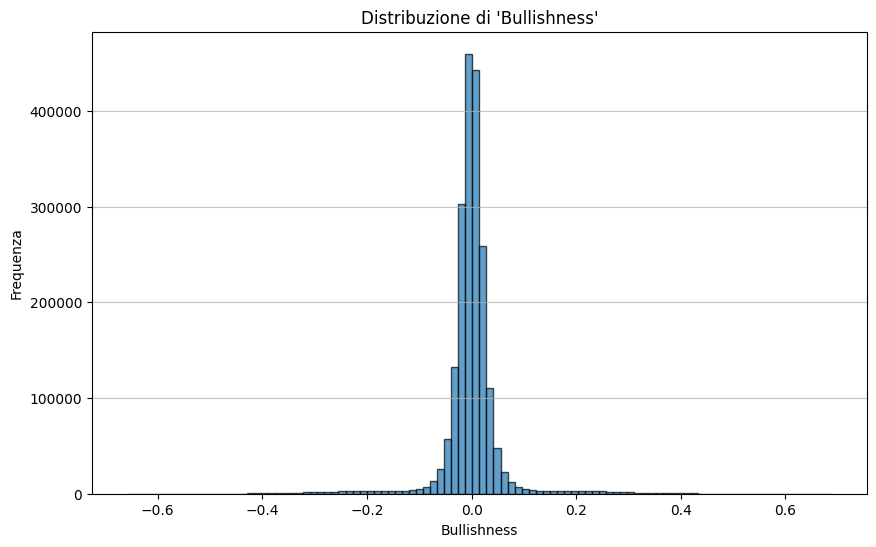

In [39]:
# Esempio di utilizzo
plot_distribution("Bullishness", combinazioni_datasets)

In [22]:
def trova_valori_estremi(datasets):
    # Trova i valori massimi e minimi di bullishness, volatility e autocorrelation
    max_bullishness_val = max(dataset['Bullishness'] for dataset in datasets)
    min_bullishness_val = min(dataset['Bullishness'] for dataset in datasets)
    max_volatility_val = max(dataset['Volatility'] for dataset in datasets)
    min_volatility_val = min(dataset['Volatility'] for dataset in datasets)
    max_autocorrelation_val = max(dataset['Autocorrelation'] for dataset in datasets)
    min_autocorrelation_val = min(dataset['Autocorrelation'] for dataset in datasets)

    # Trova gli indici dei dataset estremi basandosi sui valori scalari
    extreme_indices = {
        "max_bullishness": next(i for i, dataset in enumerate(datasets) if dataset['Bullishness'] == max_bullishness_val),
        "min_bullishness": next(i for i, dataset in enumerate(datasets) if dataset['Bullishness'] == min_bullishness_val),
        "max_volatility": next(i for i, dataset in enumerate(datasets) if dataset['Volatility'] == max_volatility_val),
        "min_volatility": next(i for i, dataset in enumerate(datasets) if dataset['Volatility'] == min_volatility_val),
        "max_autocorrelation": next(i for i, dataset in enumerate(datasets) if dataset['Autocorrelation'] == max_autocorrelation_val),
        "min_autocorrelation": next(i for i, dataset in enumerate(datasets) if dataset['Autocorrelation'] == min_autocorrelation_val),
    }

    # Estrai i dataset estremi usando gli indici trovati
    extreme_datasets = {key: datasets[index] for key, index in extreme_indices.items()}

    # Ritorna i dizionari con i dataset estremi e i loro indici
    return extreme_datasets, extreme_indices

In [23]:
prices = combinazioni_datasets[696215]['Price']
differenze_prezzo = np.diff(prices)
bullishness = 2 * (np.sum(differenze_prezzo[differenze_prezzo > 0]) / np.sum(np.abs(differenze_prezzo))) - 1
bullishness

np.float64(-0.03642222693837127)


Dataset con valore estremo per max_bullishness (Dataset #1914564):


{'Price': array([0.17775426, 0.45611503, 0.5186167 , 0.64313435, 0.83545353,
        0.7604898 , 0.72817378, 0.82551987, 0.93316656, 1.16923643,
        1.36361707, 1.24573358, 1.27143752, 1.5560478 , 1.87112628,
        1.86790366, 1.87237523, 2.1906432 , 2.27104227, 2.54893929,
        2.81323172, 2.68742659, 2.81164303, 3.10242706, 2.93952492,
        2.97313102, 3.08560621, 3.1528329 , 3.13341465, 3.17886919,
        3.20244993, 3.40334645, 3.57887966, 3.30981369, 3.40056745,
        3.49716318, 3.74467395, 3.65871869, 3.95237888, 4.15134652,
        4.5230332 , 4.61755099, 4.6828559 , 4.64860747, 4.90714185,
        4.91252004, 5.14340496, 5.08939547, 5.05211589, 5.03913048,
        4.9390299 , 5.05395191, 5.33464464, 5.60774889, 5.62468595,
        6.04425907, 5.9497    , 6.08997202, 6.24111465, 6.12131966]),
 'Bullishness': 0.6885034912457368,
 'Volatility': 0.20542682953188632,
 'Autocorrelation': 0.9961327060594404,
 'Bullishness_Cluster': Interval(0.68, 0.69, closed='right'),

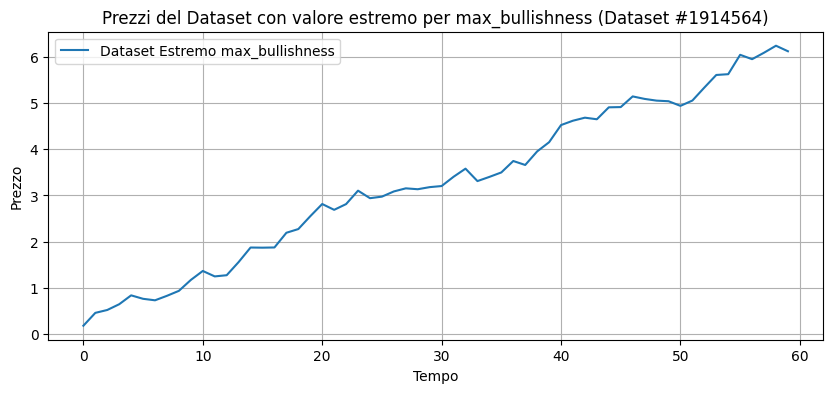


Dataset con valore estremo per min_bullishness (Dataset #1941487):


{'Price': array([11.48056166, 11.43801198, 11.45341249, 11.41789195, 11.37830039,
        11.28490673, 11.26785335, 11.25898622, 11.26511598, 11.28125163,
        11.24742938, 11.29102649, 11.29500178, 11.32166   , 11.32918309,
        11.26255716, 11.24508232, 11.2480259 , 11.24767444, 11.24994723,
        11.14841867, 11.06800714, 11.0452236 , 11.0176977 , 11.0111859 ,
        10.93848965, 10.91376062, 10.9465115 , 10.86499549, 10.86688178,
        10.88309318, 10.91768018, 10.83420845, 10.79091521, 10.77746112,
        10.7399679 , 10.76988937, 10.76922074, 10.77311446, 10.71866637,
        10.71201202, 10.69919648, 10.63409584, 10.66129144, 10.72958135,
        10.69968122, 10.70776783, 10.63983701, 10.50175006, 10.41695113,
        10.37359367, 10.29173202, 10.18433507, 10.21038753, 10.19871064,
        10.20877622, 10.12271265, 10.11756063, 10.02590024, 10.        ]),
 'Bullishness': -0.6586962003519776,
 'Volatility': 0.00308366200657438,
 'Autocorrelation': 0.9942042728366488,


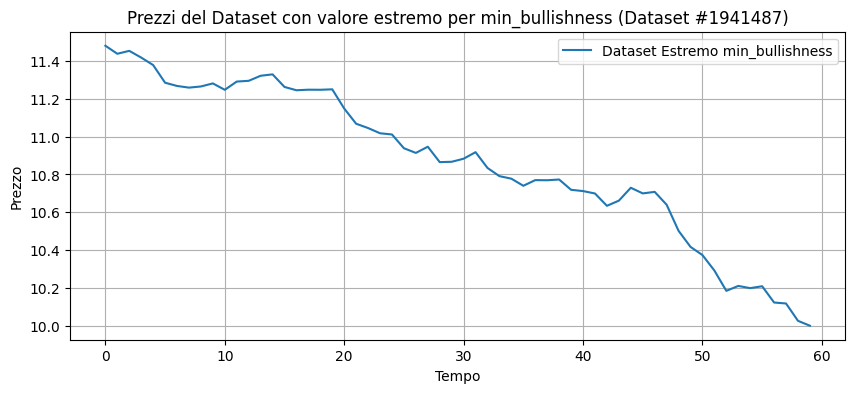


Dataset con valore estremo per max_volatility (Dataset #696215):


{'Price': array([2.03014537e+01, 1.35508954e+01, 7.65833254e+00, 1.39816846e+01,
        1.36594995e+01, 1.46428407e+01, 2.08163698e+01, 4.96592713e+00,
        2.52882117e+01, 7.95362186e+00, 1.10061245e+01, 1.62164925e+01,
        1.70218784e+01, 9.50827556e+00, 4.11039555e+00, 2.65828915e+01,
        6.14997897e+00, 2.70161579e+01, 3.09963053e-04, 3.10299940e+01,
        1.66867640e+01, 1.22341522e+01, 1.36300901e+01, 1.97127966e+01,
        1.50736308e+01, 1.61461247e+01, 9.93302718e+00, 1.83917502e+01,
        7.25304942e+00, 1.34085498e+01, 2.02180862e+01, 1.41457230e+01,
        1.99807638e+01, 2.38614667e+01, 1.69732381e+01, 1.43705970e+01,
        1.96597753e+01, 7.11817570e+00, 1.04825434e+01, 8.16943652e+00,
        1.33509977e+01, 1.52233060e+01, 5.02513673e+00, 1.69423197e+01,
        1.00580951e+01, 5.85123630e+00, 1.56245162e+01, 1.03231794e+01,
        2.25408673e+01, 6.32502773e+00, 1.61210545e+01, 3.99400730e+00,
        1.49767637e+01, 5.44828707e+00, 2.83930030e+01,

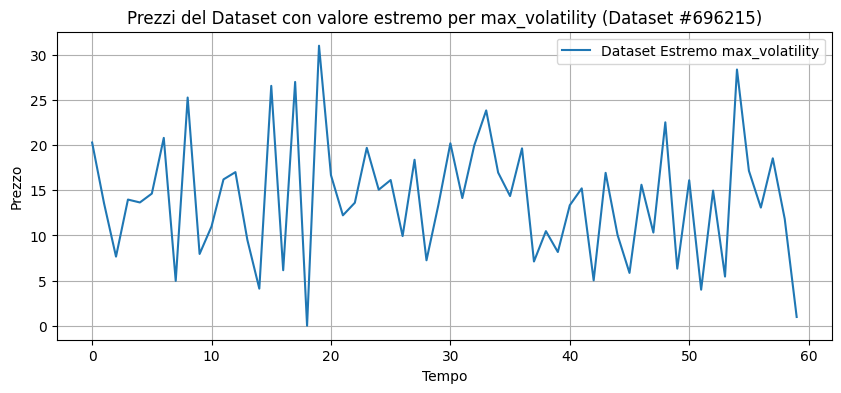


Dataset con valore estremo per min_volatility (Dataset #1910219):


{'Price': array([10.00117894, 10.00086412, 10.00035711, 10.00056928, 10.00015593,
        10.00037272, 10.00004611, 10.        , 10.00042667, 10.00088844,
        10.00160106, 10.00152607, 10.0014174 , 10.00138045, 10.00173109,
        10.0014258 , 10.00105684, 10.00146816, 10.00190078, 10.00232886,
        10.00203367, 10.00184163, 10.00159843, 10.00196206, 10.00213226,
        10.00167881, 10.00196967, 10.00237801, 10.00263239, 10.00213567,
        10.00265611, 10.00281018, 10.0026184 , 10.00334827, 10.0030434 ,
        10.00324594, 10.00300826, 10.00300598, 10.00337601, 10.00378502,
        10.00333428, 10.00378733, 10.00368206, 10.00335375, 10.00367404,
        10.00391306, 10.00382038, 10.00436982, 10.00475071, 10.00451936,
        10.00511102, 10.00443087, 10.00476915, 10.00440183, 10.00431081,
        10.00435525, 10.00422126, 10.00393588, 10.00409957, 10.00474914]),
 'Bullishness': 0.1884750235131485,
 'Volatility': 1.7207384870669568e-05,
 'Autocorrelation': 0.9672645311037186

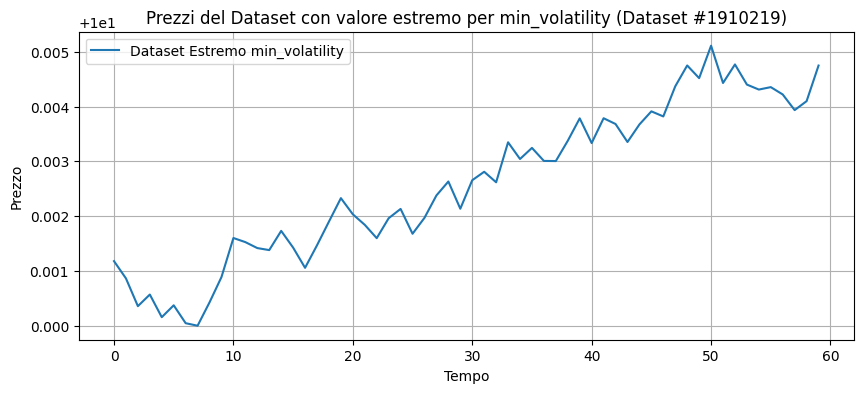


Dataset con valore estremo per max_autocorrelation (Dataset #1971628):


{'Price': array([11.49194326, 11.46202455, 11.43966709, 11.34169823, 11.34138035,
        11.41637569, 11.34966162, 11.33592452, 11.34538399, 11.38084569,
        11.36327876, 11.35926927, 11.32220645, 11.24215184, 11.22385422,
        11.20110509, 11.18093693, 11.13330686, 11.15096304, 11.13979728,
        11.14891404, 11.15861082, 11.10330317, 11.11457005, 11.0573158 ,
        11.04042669, 11.03952101, 11.05226176, 10.98651453, 10.93481113,
        10.8084101 , 10.70202637, 10.67615422, 10.59232983, 10.52126504,
        10.54287862, 10.53413966, 10.47991482, 10.47703617, 10.46300246,
        10.39038088, 10.3219003 , 10.25547974, 10.17464304, 10.17713468,
        10.1855517 , 10.19004616, 10.09088556, 10.10999748, 10.11220404,
        10.12319059, 10.09927551, 10.08704152, 10.        , 10.03704832,
        10.0145518 , 10.0841596 , 10.09898191, 10.08198465, 10.15706372]),
 'Bullishness': -0.5992924964594564,
 'Volatility': 0.0030086947770023072,
 'Autocorrelation': 0.9962244842930709

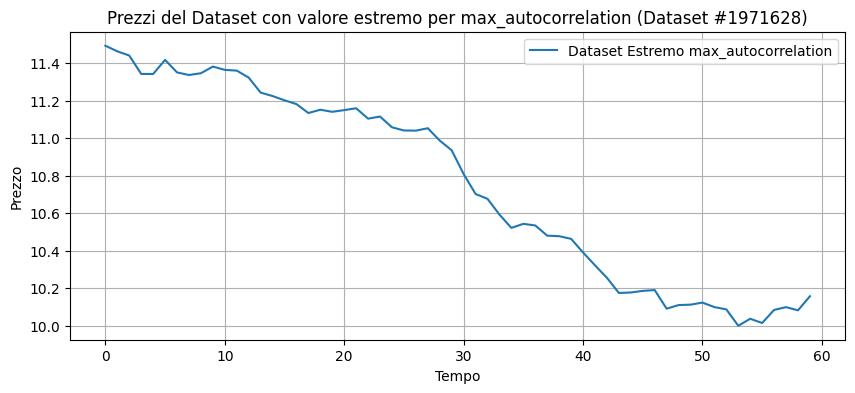


Dataset con valore estremo per min_autocorrelation (Dataset #5159):


{'Price': array([16.54901247, 16.79016548, 16.90647219, 16.58463209, 17.23060778,
        16.06160571, 17.57470959, 15.63528419, 17.71004247, 15.45399582,
        18.07041843, 15.05497826, 18.18973476, 15.33316468, 18.15823066,
        15.31128076, 18.05192208, 15.03268386, 18.44415383, 14.82193833,
        19.00873462, 14.4551865 , 18.91519961, 14.25566107, 19.42466207,
        13.86679316, 19.61570883, 13.61101711, 20.00417637, 13.32513706,
        20.10704332, 12.87406967, 21.01266722, 12.52120449, 21.07692643,
        11.92965331, 21.24337846, 12.0642703 , 21.49812634, 11.7366682 ,
        21.81145713, 11.76896634, 21.59050747, 11.68753402, 21.82923689,
        11.34216927, 22.2074753 , 10.94966663, 22.25389247, 11.46146766,
        21.9956299 , 11.32130052, 22.31010427, 10.81986627, 22.66109737,
        10.58757947, 23.15645813, 10.18291625, 23.2178149 , 10.        ]),
 'Bullishness': -0.016214328636450115,
 'Volatility': 0.31498338512700397,
 'Autocorrelation': -0.998917793404056

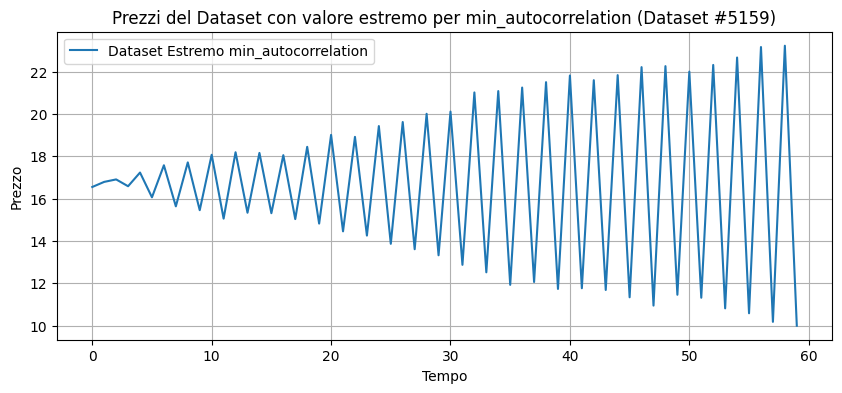

In [24]:
# Esegui la funzione su tutti i dataset sintetici generati
extreme_datasets, extreme_indices = trova_valori_estremi(combinazioni_datasets)

# Mostra i risultati e genera il plot dei prezzi per ciascun dataset
for key, dataset in extreme_datasets.items():
    index = extreme_indices[key]
    print(f"\nDataset con valore estremo per {key} (Dataset #{index}):")
    display(dataset)  # Visualizza il dizionario
    
    # Plotta i prezzi del dataset
    plt.figure(figsize=(10, 4))
    plt.plot(dataset['Price'], label=f"Dataset Estremo {key}")
    plt.title(f"Prezzi del Dataset con valore estremo per {key} (Dataset #{index})")
    plt.xlabel("Tempo")
    plt.ylabel("Prezzo")
    plt.legend()
    plt.grid()
    plt.show()

In [40]:
# Ora chiedo certi target che spero di trovare in mezzo a tutte le combinazioni generate
target_bullishness = 0
target_volatility = 0.01
target_autocorrelation = 0.9
delta_1 = 0.01
delta_2 = 0.01
delta_3 = 0.01

datasets_trovati_statistiche, datasets_trovati = filtra_datasets_per_target(
    combinazioni_cluster_stats, combinazioni_datasets, target_bullishness, target_volatility, target_autocorrelation, delta_1, delta_2, delta_3
)

Trovati 249 dataset con i target richiesti entro i margini specificati.


In [41]:
datasets_trovati_statistiche

,Bullishness_Cluster,Volatility_Cluster,Count,Avg_Bullishness,Std_Bullishness,Avg_Volatility,Std_Volatility,Avg_Autocorrelation,Std_Autocorrelation,Target_Autocorrelation,Mu_Noise,Sigma_Noise
224160,"(8.88e-16, 0.01]","(0.01, 0.02]",2,0.006921,0.000134,0.018159,0.001940,0.898892,0.040128,0.893842,-1.111111,1.12
229528,"(-0.01, 8.88e-16]","(0.01, 0.02]",2,-0.007855,0.001214,0.018851,0.000018,0.907617,0.042675,0.893842,10.000000,1.12


In [42]:
datasets_trovati[0]

{'Price': array([10.01069869, 10.01079318, 10.01595396, 10.01735983, 10.00949733,
        10.00864885, 10.00916969, 10.01594649, 10.00864445, 10.00778016,
        10.        , 10.00808031, 10.00824227, 10.01368127, 10.0151231 ,
        10.01795167, 10.02108173, 10.02128134, 10.01868165, 10.01713268,
        10.01826625, 10.01437319, 10.01372774, 10.01918896, 10.02220778,
        10.01760778, 10.02267136, 10.02549734, 10.03145715, 10.03479881,
        10.03446262, 10.02973285, 10.02927574, 10.03212306, 10.02928146,
        10.03771821, 10.03693228, 10.04168949, 10.03670188, 10.03028192,
        10.02400002, 10.02709353, 10.03575608, 10.03524164, 10.03184917,
        10.03404075, 10.03044896, 10.02576692, 10.02538544, 10.02060948,
        10.02251541, 10.01705324, 10.01168509, 10.01407625, 10.01539055,
        10.00803271, 10.01054212, 10.01645566, 10.01520243, 10.01209518]),
 'Bullishness': 0.0066266092216120676,
 'Volatility': 0.00024471104546369655,
 'Autocorrelation': 0.9004040950759

In [61]:
datasets_sintetici_desiderati = 50
datasets_sintetici = datasets_trovati[:datasets_sintetici_desiderati]

In [60]:
def convert_to_dataframes(datasets):
    """
    Converte una lista di dizionari in una lista di DataFrame, dove ogni DataFrame
    ha una colonna 'Timestamp' a partire dal 1 gennaio 2000 e una colonna 'Price'.

    Parametri:
    - datasets (list): Lista di dizionari con una chiave 'Price' contenente i prezzi.

    Ritorna:
    - List: Lista di DataFrame con colonne 'Timestamp' e 'Price'.
    """
    dataframes = []
    
    for dataset in datasets:
        prices = dataset['Price']
        
        # Crea la colonna Timestamp partendo dal 1 gennaio 2000
        timestamps = pd.date_range(start='2000-01-01', periods=len(prices), freq='D')
        
        # Crea il DataFrame con Timestamp e Price
        df = pd.DataFrame({
            'Timestamp': timestamps,
            'Price': prices
        })
        
        dataframes.append(df)
    
    return dataframes

In [63]:
# Esegui la conversione
datasets_sintetici = convert_to_dataframes(datasets_sintetici)

# Visualizza il primo DataFrame come esempio
datasets_sintetici[0]

,Timestamp,Price
0,2000-01-01,10.010699
1,2000-01-02,10.010793
2,2000-01-03,10.015954
3,2000-01-04,10.017360
4,2000-01-05,10.009497
5,2000-01-06,10.008649
6,2000-01-07,10.009170
7,2000-01-08,10.015946
8,2000-01-09,10.008644
9,2000-01-10,10.007780


# 3. Applicazione della strategia di trading a ciascun dataset

In [44]:
# Funzione per calcolare l'ultimo prezzo di riferimento discesa
def calcola_prezzo_riferimento_discesa(dati, soglia_discesa):
    variazione_cumulata = 1
    cont = 0

    for j in range(len(dati), 0, -1):
        variazione_giorno_precedente = dati['Variazione'].iloc[j-1]

        if pd.isna(variazione_giorno_precedente):
            continue

        if variazione_giorno_precedente < 1:  # Prezzo in discesa
            variazione_cumulata = 1
            cont = 0
        else:
            variazione_cumulata *= variazione_giorno_precedente
            if variazione_cumulata != variazione_giorno_precedente:
                cont += 1
            if variazione_cumulata - 1 >= soglia_discesa:
                # Se la variazione supera la soglia, restituisci il riferimento
                if j + cont - 1 == len(dati) - 1:
                    # Se il riferimento è l'ultimo giorno, restituisci None
                    return None, None
                return dati['Timestamp'].iloc[j+cont-1], dati['Price'].iloc[j+cont-1]

    # Se non si è trovata una variazione che supera la soglia, ritorna il primo giorno
    return dati['Timestamp'].iloc[0], dati['Price'].iloc[0]

# Funzione per calcolare l'ultimo prezzo di riferimento salita
def calcola_prezzo_riferimento_salita(dati, soglia_salita):
    variazione_cumulata = 1
    cont = 0

    for j in range(len(dati), 0, -1):
        variazione_giorno_precedente = dati['Variazione'].iloc[j-1]

        if pd.isna(variazione_giorno_precedente):
            continue

        if variazione_giorno_precedente > 1:  # Prezzo in salita
            variazione_cumulata = 1
            cont = 0
        else:
            variazione_cumulata *= variazione_giorno_precedente
            if variazione_cumulata != variazione_giorno_precedente:
                cont += 1
            if 1 - variazione_cumulata >= soglia_salita:
                # Se la variazione supera la soglia o il prezzo di riferimento è superiore al prezzo attuale, restituisci il riferimento
                if j + cont - 1 == len(dati) - 1:
                    # Se il riferimento è l'ultimo giorno, restituisci None
                    return None, None
                return dati['Timestamp'].iloc[j+cont-1], dati['Price'].iloc[j+cont-1]

    # Se non si è trovata una variazione che supera la soglia, ritorna il primo giorno
    return dati['Timestamp'].iloc[0], dati['Price'].iloc[0]

def calcola_percentuale(variazione, coefficienti, A, B):
    if isinstance(coefficienti, list):
        # Se coefficienti è una lista, esegue la somma ponderata delle variazioni
        return min(max(sum([c * variazione ** i for i, c in enumerate(coefficienti)]), 0), 1)
    
    elif isinstance(coefficienti, str) and coefficienti != 'custom_exp':
        # Se coefficienti è una stringa, interpreta la stringa come una formula matematica
        # Sostituisci 'x' con il valore di variazione
        formula = coefficienti.replace('x', str(variazione))
        # Usa eval per calcolare il risultato
        try:
            risultato = eval(formula)
        except Exception as e:
            raise ValueError(f"Errore nell'interpretazione della formula: {e}")
        return min(max(risultato, 0), 1)
    
    elif coefficienti == 'custom_exp':
        return eval(f'variazione ** {A} / ({B} + (1 - {B}) * variazione ** {A})')
    
    else:
        raise TypeError("Il parametro 'coefficienti' deve essere una lista, una stringa o 'custom_exp'.")

In [56]:
def trading_perc_senza_micro_variazioni_velocizzato(dati, inverti_riferimento_acquisto, inverti_riferimento_vendita, acquisto_rispetto_liquidità_iniziale, vendita_rispetto_massimo_btc_posseduti,
     compra_pure, vendi_pure, soglia_vendita, A_a, B_a, A_v, B_v, coefficienti_acquisto, coefficienti_vendita,
     compra_solo_in_discesa, vendi_solo_in_salita, soglia_acquisto_rispetto_riferimento,
     soglia_vendita_rispetto_riferimento, soglia_calcolo_variazioni_discesa, soglia_calcolo_variazioni_salita, perc_relativa, finestra_minimo, finestra_massimo, nuovi_min_all_in, nuovi_max_all_in, soglia_acquisti_vicini, soglia_vendite_vicine, liquidità_iniziale, bitcoin_iniziali):
    

    # Parametri iniziali
    liquidità = liquidità_iniziale
    bitcoin = bitcoin_iniziali
    valore_totale_portafoglio = liquidità + bitcoin * dati['Price'][0]

    # Calcolo variazioni giornaliere
    dati['Variazione'] = dati['Price'] / dati['Price'].shift(1)

    # Inizializza la lista delle transazioni
    transazioni = []

    # Variabili per tenere traccia degli acquisti consecutivi
    acquisti_consecutivi = []
    quantità_euro_totale = 0  # Somma totale degli euro spesi negli acquisti consecutivi

    liquidità_iniziale_in_btc = liquidità_iniziale / dati['Price'].iloc[0]

    ultimo_prezzo_acquisto = None
    ultimo_prezzo_vendita = None
    ultima_azione = None
    azione = None


    # Simulazione del trading giorno per giorno
    for i in range(1, len(dati)):
        # data_odierna = dati['Timestamp'].iloc[i]
        prezzo_attuale = dati['Price'].iloc[i]
        variazione_giornaliera_prezzo_percentuale = (dati['Variazione'].iloc[i] - 1) * 100
        if perc_relativa:
            if finestra_minimo <= i:
                minimo_ultimi_giorni = np.min(dati['Price'].iloc[i-finestra_minimo:i+1])

            else:
                minimo_ultimi_giorni = np.min(dati['Price'].iloc[:i+1])

            if finestra_massimo <= i:
                massimo_ultimi_giorni = np.max(dati['Price'].iloc[i-finestra_massimo:i+1])

            else:
                massimo_ultimi_giorni = np.max(dati['Price'].iloc[:i+1])
        
        # Calcola i prezzi di riferimento discesa e salita
        timestamp_riferimento_discesa, prezzo_riferimento_discesa = calcola_prezzo_riferimento_discesa(dati.iloc[:i+1], soglia_calcolo_variazioni_discesa)
        timestamp_riferimento_salita, prezzo_riferimento_salita = calcola_prezzo_riferimento_salita(dati.iloc[:i+1], soglia_calcolo_variazioni_salita)
        # timestamp_riferimento_discesa, prezzo_riferimento_discesa = rif_discesa_sbagliato(dati.iloc[:i], soglia_calcolo_variazioni_discesa)
        # timestamp_riferimento_salita, prezzo_riferimento_salita = rif_salita_sbagliato(dati.iloc[:i], soglia_calcolo_variazioni_salita)

        # Scegli il prezzo di riferimento più recente (se esiste)
        prezzo_riferimento = None
        if prezzo_riferimento_discesa is not None and prezzo_riferimento_salita is not None:
            if timestamp_riferimento_discesa > timestamp_riferimento_salita:
                prezzo_riferimento = prezzo_riferimento_discesa
                tipo_riferimento = 'discesa'
            else:
                prezzo_riferimento = prezzo_riferimento_salita
                tipo_riferimento = 'salita'
        elif prezzo_riferimento_discesa is not None:
            prezzo_riferimento = prezzo_riferimento_discesa
            tipo_riferimento = 'discesa'
        elif prezzo_riferimento_salita is not None:
            prezzo_riferimento = prezzo_riferimento_salita
            tipo_riferimento = 'salita'

        # Se nessun riferimento è disponibile, passa al giorno successivo
        if prezzo_riferimento is None:
            continue

        # Variabili per tracciare l'azione e la transazione
        azione = '-'
        # percentuale_liquidità_usata = 0
        # percentuale_bitcoin_usata = 0
        # percentuale_liquidità_usata_rispetto_rif = 0
        # percentuale_bitcoin_usata_rispetto_rif = 0
        # euro_spesi_o_ricavati = 0
        # bitcoin_acquistati_o_venduti = 0

        # Logica di acquisto o vendita in base al riferimento più recente
        if tipo_riferimento == 'discesa':  # Logica di acquisto
            if not perc_relativa:
                if inverti_riferimento_acquisto:
                    variazione_percentuale = (prezzo_riferimento_discesa - prezzo_attuale) / prezzo_attuale
                else:
                    variazione_percentuale = (prezzo_riferimento_discesa - prezzo_attuale) / prezzo_riferimento_discesa
            else:
                den = prezzo_riferimento_discesa - minimo_ultimi_giorni
                if den > 0: # Aggiungo questo controllo perchè in generale potrebbe anche accadere che il minimo sia superiore all'ultimo prezzo_riferimento_discesa salvato
                    num = prezzo_riferimento_discesa - prezzo_attuale
                    variazione_percentuale = num / den
                    if not nuovi_min_all_in and variazione_percentuale == 1:
                        if inverti_riferimento_acquisto:
                            variazione_percentuale = (prezzo_riferimento_discesa - prezzo_attuale) / prezzo_attuale
                        else:
                            variazione_percentuale = (prezzo_riferimento_discesa - prezzo_attuale) / prezzo_riferimento_discesa
                else:
                    variazione_percentuale = 0


            percentuale_acquisto = calcola_percentuale(abs(variazione_percentuale), coefficienti_acquisto, A_a, B_a)
            liquidità_da_usare = liquidità_iniziale if acquisto_rispetto_liquidità_iniziale else liquidità
            euro_da_spendere = liquidità_da_usare * percentuale_acquisto

            if euro_da_spendere > liquidità:
                if compra_pure:
                    euro_da_spendere = liquidità  # Usa tutto
                else:
                    euro_da_spendere = 0  # Non fare niente

            if euro_da_spendere > 0 and (compra_solo_in_discesa and variazione_giornaliera_prezzo_percentuale < 0 or not compra_solo_in_discesa) and prezzo_attuale < prezzo_riferimento_discesa * (1 - soglia_acquisto_rispetto_riferimento) and (soglia_acquisti_vicini > 0 and ultimo_prezzo_acquisto is not None and ultima_azione == 'Acquisto' and abs(prezzo_attuale - ultimo_prezzo_acquisto) >= soglia_acquisti_vicini * ultimo_prezzo_acquisto or soglia_acquisti_vicini == 0 or ultima_azione is None):
                # percentuale_liquidità_usata = euro_da_spendere / liquidità
                bitcoin_acquistati = euro_da_spendere / prezzo_attuale
                liquidità -= euro_da_spendere
                bitcoin += bitcoin_acquistati
                azione = 'Acquisto'
                ultima_azione = azione
                # percentuale_liquidità_usata_rispetto_rif = percentuale_acquisto
                # euro_spesi_o_ricavati = euro_da_spendere
                # bitcoin_acquistati_o_venduti = bitcoin_acquistati
                
                # Aggiungi questo acquisto alla lista degli acquisti consecutivi
                acquisti_consecutivi.append((prezzo_attuale, euro_da_spendere))
                quantità_euro_totale += euro_da_spendere
                ultimo_prezzo_acquisto = prezzo_attuale

        elif tipo_riferimento == 'salita':  # Logica di vendita
            if not perc_relativa:
                if inverti_riferimento_vendita:
                    variazione_percentuale = (prezzo_attuale - prezzo_riferimento_salita) / prezzo_attuale
                else:
                    variazione_percentuale = (prezzo_attuale - prezzo_riferimento_salita) / prezzo_riferimento_salita
            else:
                den = massimo_ultimi_giorni - prezzo_riferimento_salita
                if den > 0: # Aggiungo questo controllo perchè in generale potrebbe anche accadere che il massimo sia inferiore all'ultimo prezzo_riferimento_salita salvato
                    num = prezzo_attuale - prezzo_riferimento_salita
                    variazione_percentuale = num / den
                    if not nuovi_max_all_in and variazione_percentuale == 1:
                        if inverti_riferimento_vendita:
                            variazione_percentuale = (prezzo_attuale - prezzo_riferimento_salita) / prezzo_attuale
                        else:
                            variazione_percentuale = (prezzo_attuale - prezzo_riferimento_salita) / prezzo_riferimento_salita
                else:
                    variazione_percentuale = 0

            percentuale_vendita = calcola_percentuale(abs(variazione_percentuale), coefficienti_vendita, A_v, B_v)
            bitcoin_da_usare = liquidità_iniziale_in_btc if vendita_rispetto_massimo_btc_posseduti else bitcoin
            bitcoin_da_vendere = bitcoin_da_usare * percentuale_vendita


            # Controllo del prezzo di vendita rispetto alla media pesata degli acquisti consecutivi
            if acquisti_consecutivi:
                # Calcolo della media pesata dei prezzi di acquisto
                somma_pesata = sum(prezzo * euro for prezzo, euro in acquisti_consecutivi)
                media_pesata_acquisti = somma_pesata / quantità_euro_totale

                # Verifica che il prezzo attuale sia superiore alla soglia rispetto alla media pesata
                if prezzo_attuale <= media_pesata_acquisti * (1 + soglia_vendita):
                    # Se non soddisfa la soglia di vendita, non fare niente
                    bitcoin_da_vendere = 0

            if bitcoin_da_vendere > bitcoin:
                if vendi_pure:
                    bitcoin_da_vendere = bitcoin  # Vendi tutto
                else:
                    bitcoin_da_vendere = 0  # Non fare niente

            if bitcoin_da_vendere > 0 and (vendi_solo_in_salita and variazione_giornaliera_prezzo_percentuale > 0 or not vendi_solo_in_salita) and prezzo_attuale > prezzo_riferimento_salita * (1 + soglia_vendita_rispetto_riferimento) and (soglia_vendite_vicine > 0 and ultimo_prezzo_vendita is not None and ultima_azione == 'Vendita' and abs(prezzo_attuale - ultimo_prezzo_vendita) >= soglia_vendite_vicine * ultimo_prezzo_vendita or soglia_vendite_vicine == 0 or ultima_azione is None):
                # percentuale_bitcoin_usata = bitcoin_da_vendere / bitcoin
                euro_ricavati = bitcoin_da_vendere * prezzo_attuale
                bitcoin -= bitcoin_da_vendere
                liquidità += euro_ricavati
                azione = 'Vendita'
                ultima_azione = azione
                # percentuale_bitcoin_usata_rispetto_rif = percentuale_vendita
                # euro_spesi_o_ricavati = euro_ricavati
                # bitcoin_acquistati_o_venduti = bitcoin_da_vendere

                # Reset degli acquisti consecutivi dopo una vendita
                acquisti_consecutivi = []
                quantità_euro_totale = 0
                ultimo_prezzo_vendita = prezzo_attuale


        # Aggiorna il valore totale del portafoglio
        valore_totale_portafoglio = liquidità + (bitcoin * prezzo_attuale)

        # variazione_perc_rispetto_riferimento_discesa = (prezzo_attuale / prezzo_riferimento_discesa - 1) * 100 if prezzo_riferimento_discesa else None
        # variazione_perc_rispetto_riferimento_salita = (prezzo_attuale / prezzo_riferimento_salita - 1) * 100 if prezzo_riferimento_salita else None

        # Salva la transazione nella lista
        nuova_transazione = {
            # 'data': data_odierna,
            'prezzo': prezzo_attuale,
            # 'variazione_giornaliera_prezzo_percentuale': round(variazione_giornaliera_prezzo_percentuale, 2),
            # 'timestamp_riferimento_discesa': timestamp_riferimento_discesa,
            # 'prezzo_riferimento_discesa': prezzo_riferimento_discesa,
            # 'variazione_rispetto_riferimento_discesa': round((prezzo_attuale / prezzo_riferimento_discesa - 1) * 100, 2) if prezzo_riferimento_discesa else None,
            # 'timestamp_riferimento_salita': timestamp_riferimento_salita,
            # 'prezzo_riferimento_salita': prezzo_riferimento_salita,
            # 'variazione_rispetto_riferimento_salita': round((prezzo_attuale / prezzo_riferimento_salita - 1) * 100, 2) if prezzo_riferimento_salita else None,
            # 'azione': azione,
            # 'percentuale_liquidità_usata': percentuale_liquidità_usata,
            # 'percentuale_bitcoin_usata': percentuale_bitcoin_usata,
            # 'quantità_euro': euro_spesi_o_ricavati,
            # 'bitcoin_acquistati_o_venduti': bitcoin_acquistati_o_venduti,
            # 'liquidità': liquidità,
            'bitcoin': bitcoin,
            'valore_totale_portafoglio': valore_totale_portafoglio
        }
        transazioni.append(nuova_transazione)

    # Crea il DataFrame delle transazioni alla fine
    df_transazioni = pd.DataFrame(transazioni)

    return df_transazioni

In [64]:
# Creazione del dizionario 'parametri'
parametri_variabili = {
    "inverti_riferimento_acquisto": True,
    "inverti_riferimento_vendita": True,
    "acquisto_rispetto_liquidità_iniziale": True,
    "vendita_rispetto_massimo_btc_posseduti": True,
    "compra_pure": True,
    "vendi_pure": True,
    "soglia_vendita": 0,
    "A_a": 10,
    "B_a": 0.001,
    "A_v": 10,
    "B_v": 0.001,
    "coefficienti_acquisto": 'custom_exp',
    "coefficienti_vendita": 'custom_exp',
    "compra_solo_in_discesa": True,
    "vendi_solo_in_salita": False,
    "soglia_acquisto_rispetto_riferimento": 0,
    "soglia_vendita_rispetto_riferimento": 0,
    "soglia_calcolo_variazioni_discesa": 0.05,
    "soglia_calcolo_variazioni_salita": 0.05,
    "perc_relativa": False,
    "finestra_minimo": 30,
    "finestra_massimo": 30,
    "nuovi_min_all_in": False,
    "nuovi_max_all_in": False,
    "soglia_acquisti_vicini": 0.05,
    "soglia_vendite_vicine": 0.05
}

parametri_fissi = {
    "liquidità_iniziale": 1000,
    "bitcoin_iniziali": 0
}

# Applicazione della strategia a ciascun dataset
portfolio_results = []
for dataset in datasets_sintetici:
    df_transazioni = trading_perc_senza_micro_variazioni_velocizzato(dataset, **parametri_variabili, **parametri_fissi)
    portfolio_results.append(df_transazioni["valore_totale_portafoglio"])

In [65]:
portfolio_results[0]

0     1000.0
1     1000.0
2     1000.0
3     1000.0
4     1000.0
5     1000.0
6     1000.0
7     1000.0
8     1000.0
9     1000.0
10    1000.0
11    1000.0
12    1000.0
13    1000.0
14    1000.0
15    1000.0
16    1000.0
17    1000.0
18    1000.0
19    1000.0
20    1000.0
21    1000.0
22    1000.0
23    1000.0
24    1000.0
25    1000.0
26    1000.0
27    1000.0
28    1000.0
29    1000.0
30    1000.0
31    1000.0
32    1000.0
33    1000.0
34    1000.0
35    1000.0
36    1000.0
37    1000.0
38    1000.0
39    1000.0
40    1000.0
41    1000.0
42    1000.0
43    1000.0
44    1000.0
45    1000.0
46    1000.0
47    1000.0
48    1000.0
49    1000.0
50    1000.0
51    1000.0
52    1000.0
53    1000.0
54    1000.0
55    1000.0
56    1000.0
57    1000.0
58    1000.0
Name: valore_totale_portafoglio, dtype: float64

# 4. Calcolo del rendimento e analisi del range dei rendimenti (epsilon)

Bullishness target: 0 con delta_1 accettabile di 0.01
Bullishness media: 0.00010, Differenza max-min bullishness: 0.01969

Volatilità target: 0.01 con delta_2 accettabile di 0.01
Volatilità media: 0.00104, Differenza max-min volatilità: 0.01947

Autocorrelazione target (lag 1): 0.9 con delta_3 accettabile di 0.01
Autocorrelazione media: 0.89889, Differenza max-min autocorrelazione: 0.01868

Rendimento medio: 1.00003 con epsilon di 1.0013547565912806 - 1.0 = 0.00135


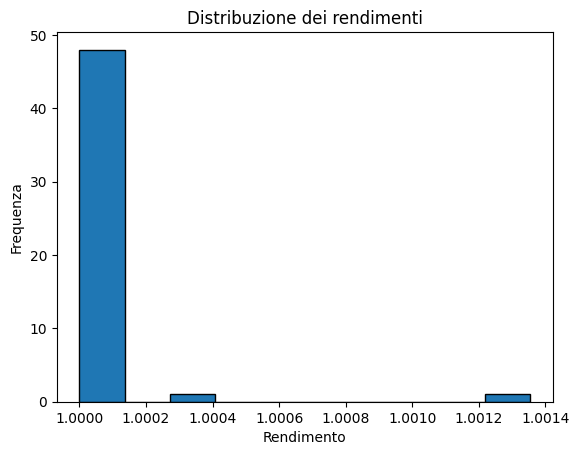

In [69]:
# Funzione per calcolare il rendimento del dataset
def calculate_return(portfolio_values):
    return portfolio_values.iloc[-1] / portfolio_values.iloc[0]

# Liste per bullishness, volatilità e autocorrelazione
bullishness_list = []
volatility_list = []
autocorrelation_list = []

# Calcoliamo bullishness, volatilità e autocorrelazione per ciascun dataset sintetico
for dataset in datasets_sintetici:
    prezzi = dataset["Price"].values
    bullishness_list.append(calculate_bullishness(prezzi))
    volatility_list.append(calculate_volatility(prezzi))
    autocorrelation_list.append(calculate_autocorrelation(prezzi))

# Calcoliamo il rendimento per ciascun dataset
returns = [calculate_return(portfolio) for portfolio in portfolio_results]

# Calcoliamo le statistiche richieste
bullishness_mean = np.mean(bullishness_list)
bullishness_delta = max(bullishness_list) - min(bullishness_list)

volatility_mean = np.mean(volatility_list)
volatility_delta = max(volatility_list) - min(volatility_list)

autocorrelation_mean = np.mean(autocorrelation_list)
autocorrelation_delta = max(autocorrelation_list) - min(autocorrelation_list)

epsilon = max(returns) - min(returns) # Differenza tra rendimento massimo e minimo

# Stampa dei risultati
print(f"Bullishness target: {target_bullishness} con delta_1 accettabile di {delta_1}")
print(f"Bullishness media: {bullishness_mean:.5f}, Differenza max-min bullishness: {bullishness_delta:.5f}\n")

print(f"Volatilità target: {target_volatility} con delta_2 accettabile di {delta_2}")
print(f"Volatilità media: {volatility_mean:.5f}, Differenza max-min volatilità: {volatility_delta:.5f}\n")

print(f"Autocorrelazione target (lag 1): {target_autocorrelation} con delta_3 accettabile di {delta_3}")
print(f"Autocorrelazione media: {autocorrelation_mean:.5f}, Differenza max-min autocorrelazione: {autocorrelation_delta:.5f}\n")

print(f"Rendimento medio: {np.mean(returns):.5f} con epsilon di {max(returns)} - {min(returns)} = {epsilon:.5f}")

# Visualizziamo i rendimenti
plt.hist(returns, bins=10, edgecolor='black')
plt.title('Distribuzione dei rendimenti')
plt.xlabel('Rendimento')
plt.ylabel('Frequenza')
plt.show()

# Notare che la "Differenza max-min" dev'essere al massimo 2 volte il delta accettabile richiesto affinchè tutto stia funzionando correttamente

# 5. Conclusione: Verifica se a delta_i minori corrispondono epsilon minori

In [ ]:
# # Liste per memorizzare i valori di delta_1 e epsilon
# delta_1_values = np.linspace(0.001, 0.1, 6)  # Valori di delta_1 da 0.001 a 0.1 con 10 step
# epsilon_values = []

# n_datasets = 5

# # Ciclo su diversi valori di delta_1
# for j, delta_1 in enumerate(delta_1_values):
#     # Genera i dataset sintetici per ogni valore di delta_1
#     datasets_sintetici = []
#     for i in range(1, n_datasets + 1):
#         print(f'Valore di delta_1 {j} / {len(delta_1_values)}: delta_1 = {delta_1}')
#         prezzi, numero_tentativi = genera_dataset_sintetico_completo(
#             L, target_bullishness, target_volatility, target_autocorrelation, delta_1, delta_2, delta_3,
#             distribuzione_variazioni_positive, distribuzione_variazioni_negative, lag, i, n_datasets
#         )
#         dataset_df = pd.DataFrame({
#             "Timestamp": pd.date_range(start='2000-01-01', periods=L),
#             "Price": prezzi
#         })
#         datasets_sintetici.append(dataset_df)

#     # Applica la strategia di trading a ciascun dataset sintetico
#     portfolio_results = []
#     for dataset in datasets_sintetici:
#         df_transazioni = trading_perc_senza_micro_variazioni_velocizzato(dataset, **parametri_variabili, **parametri_fissi)
#         portfolio_results.append(df_transazioni["valore_totale_portafoglio"])

#     # Calcola il rendimento per ciascun dataset
#     returns = [calculate_return(portfolio) for portfolio in portfolio_results]

#     # Calcola epsilon, ovvero la differenza tra rendimento massimo e minimo
#     epsilon = max(returns) - min(returns)
#     epsilon_values.append(epsilon)

#     # Stampa per il controllo
#     print(f"Per delta_1 = {delta_1:.5f}, epsilon = {epsilon:.5f}")

# # Visualizza il grafico di epsilon in funzione di delta_1
# plt.plot(delta_1_values, epsilon_values, marker='o', linestyle='-', color='b')
# plt.title('Variazione di epsilon in funzione di delta_1')
# plt.xlabel('delta_1 (Bullishness range accettabile)')
# plt.ylabel('epsilon (Differenza max-min rendimenti)')
# plt.grid(True)
# plt.show()

In [ ]:
# # Numero di combinazioni casuali di delta_i da generare
# n_combinazioni = 20

# n_datasets = 5

# # Lista per salvare i volumi e epsilon corrispondenti
# volumi = []
# epsilon_values = []

# # Definizione dei range possibili per i vari delta
# delta_1_range = np.linspace(0.001, 0.1, 10)
# delta_2_range = np.linspace(0.001, 0.1, 1)
# delta_3_range = np.linspace(0.001, 0.1, 10)

# # Genera combinazioni casuali di delta_1, delta_2, delta_3 e calcola il volume e epsilon
# for j in range(1, n_combinazioni + 1):
#     # Scelta casuale di delta_1, delta_2, delta_3
#     delta_1 = np.random.choice(delta_1_range)
#     delta_2 = np.random.choice(delta_2_range)
#     delta_3 = np.random.choice(delta_3_range)

#     # Calcola il volume dell'ipercubo
#     volume = delta_1 * delta_2 * delta_3
#     print(f'Combinazione {j}/{n_combinazioni}: {delta_1} * {delta_2} * {delta_3} = {volume}')
#     volumi.append(volume)

#     # Genera dataset sintetici con i delta scelti
#     # Nota: Supponiamo che genera_dataset_sintetico_completo restituisca epsilon per il dataset generato
#     epsilon_list = []
#     for i in range(1, n_datasets + 1):
#         dataset, _ = genera_dataset_sintetico_completo(L, target_bullishness, target_volatilita, target_autocorrelazione,
#                                                        delta_1, delta_2, delta_3, distribuzione_variazioni_positive,
#                                                        distribuzione_variazioni_negative, lag, i, n_datasets)
#         # Creiamo un DataFrame con Timestamp e Price
#         dataset_df = pd.DataFrame({
#             "Timestamp": pd.date_range(start='2000-01-01', periods=L),
#             "Price": dataset
#         })
#         # datasets_sintetici.append(dataset_df)
#         portfolio_result = trading_perc_senza_micro_variazioni_velocizzato(dataset_df, **parametri_variabili, **parametri_fissi)
#         epsilon_list.append(calculate_return(portfolio_result["valore_totale_portafoglio"]))

#     # Calcola epsilon come la differenza tra rendimento massimo e minimo
#     epsilon = max(epsilon_list) - min(epsilon_list)
#     epsilon_values.append(epsilon)

# # Calcola la correlazione di Pearson tra volume ed epsilon
# correlazione, _ = pearsonr(volumi, epsilon_values)
# print(f"Correlazione di Pearson tra volume ed epsilon: {correlazione:.5f}")

# # Grafico epsilon in funzione del volume
# plt.scatter(volumi, epsilon_values, color='b', marker='o')
# plt.title('Epsilon in funzione del Volume dell\'ipercubo')
# plt.xlabel('Volume dell\'ipercubo (delta_1 * delta_2 * delta_3)')
# plt.ylabel('Epsilon (Differenza max-min rendimenti)')
# plt.grid()
# plt.show()

In [ ]:
# # Calcolo del numero di casi in cui volume ed epsilon crescono insieme
# casi_in_cui_crescono_insieme = sum((np.diff(volumi) > 0) & (np.diff(epsilon_values) > 0))

# # Percentuale di casi in cui volume ed epsilon crescono insieme
# percentuale_crescita_concordante = (casi_in_cui_crescono_insieme / (len(volumi) - 1)) * 100
# print(f"Percentuale di casi in cui volume ed epsilon crescono insieme: {percentuale_crescita_concordante:.2f}%")

In [20]:
# Conclusione: bullishness e volatilità non sono caratteristiche sufficienti affinchè la strategia scelta possa garantire che un rendimento sarà sempre basso o sempre alto per certe bullishness e volatilità del dataset in questione

# 5.1 Conclusione corrispondente al metodo alternativo (2.1)

In [ ]:
# Ora chiedo certi target che spero di trovare in mezzo a tutte le combinazioni generate
target_bullishness = 0
target_volatility = 0.01
target_autocorrelation = 0.9
delta_1 = 0.01
delta_2 = 0.01
delta_3 = 0.01

datasets_trovati_statistiche, datasets_trovati = filtra_datasets_per_target(
    combinazioni_cluster_stats, combinazioni_datasets, target_bullishness, target_volatility, target_autocorrelation, delta_1, delta_2, delta_3
)

In [ ]:
# Liste per memorizzare i valori di delta_1 e epsilon
delta_1_values = np.linspace(0.001, 0.1, 6)  # Valori di delta_1 da 0.001 a 0.1 con 10 step
epsilon_values = []

n_datasets = 5

# Ciclo su diversi valori di delta_1
for j, delta_1 in enumerate(delta_1_values):
    # Genera i dataset sintetici per ogni valore di delta_1
    datasets_sintetici = []
    for i in range(1, n_datasets + 1):
        print(f'Valore di delta_1 {j} / {len(delta_1_values)}: delta_1 = {delta_1}')
        prezzi, numero_tentativi = genera_dataset_sintetico_completo(
            L, target_bullishness, target_volatility, target_autocorrelation, delta_1, delta_2, delta_3,
            distribuzione_variazioni_positive, distribuzione_variazioni_negative, lag, i, n_datasets
        )
        dataset_df = pd.DataFrame({
            "Timestamp": pd.date_range(start='2000-01-01', periods=L),
            "Price": prezzi
        })
        datasets_sintetici.append(dataset_df)

    # Applica la strategia di trading a ciascun dataset sintetico
    portfolio_results = []
    for dataset in datasets_sintetici:
        df_transazioni = trading_perc_senza_micro_variazioni_velocizzato(dataset, **parametri_variabili, **parametri_fissi)
        portfolio_results.append(df_transazioni["valore_totale_portafoglio"])

    # Calcola il rendimento per ciascun dataset
    returns = [calculate_return(portfolio) for portfolio in portfolio_results]

    # Calcola epsilon, ovvero la differenza tra rendimento massimo e minimo
    epsilon = max(returns) - min(returns)
    epsilon_values.append(epsilon)

    # Stampa per il controllo
    print(f"Per delta_1 = {delta_1:.5f}, epsilon = {epsilon:.5f}")

# Visualizza il grafico di epsilon in funzione di delta_1
plt.plot(delta_1_values, epsilon_values, marker='o', linestyle='-', color='b')
plt.title('Variazione di epsilon in funzione di delta_1')
plt.xlabel('delta_1 (Bullishness range accettabile)')
plt.ylabel('epsilon (Differenza max-min rendimenti)')
plt.grid(True)
plt.show()

In [ ]:
# Numero di combinazioni casuali di delta_i da generare
n_combinazioni = 20

n_datasets = 5

# Lista per salvare i volumi e epsilon corrispondenti
volumi = []
epsilon_values = []

# Definizione dei range possibili per i vari delta
delta_1_range = np.linspace(0.001, 0.1, 10)
delta_2_range = np.linspace(0.001, 0.1, 1)
delta_3_range = np.linspace(0.001, 0.1, 10)

# Genera combinazioni casuali di delta_1, delta_2, delta_3 e calcola il volume e epsilon
for j in range(1, n_combinazioni + 1):
    # Scelta casuale di delta_1, delta_2, delta_3
    delta_1 = np.random.choice(delta_1_range)
    delta_2 = np.random.choice(delta_2_range)
    delta_3 = np.random.choice(delta_3_range)

    # Calcola il volume dell'ipercubo
    volume = delta_1 * delta_2 * delta_3
    print(f'Combinazione {j}/{n_combinazioni}: {delta_1} * {delta_2} * {delta_3} = {volume}')
    volumi.append(volume)

    # Genera dataset sintetici con i delta scelti
    # Nota: Supponiamo che genera_dataset_sintetico_completo restituisca epsilon per il dataset generato
    epsilon_list = []
    for i in range(1, n_datasets + 1):
        dataset, _ = genera_dataset_sintetico_completo(L, target_bullishness, target_volatilita, target_autocorrelazione,
                                                       delta_1, delta_2, delta_3, distribuzione_variazioni_positive,
                                                       distribuzione_variazioni_negative, lag, i, n_datasets)
        # Creiamo un DataFrame con Timestamp e Price
        dataset_df = pd.DataFrame({
            "Timestamp": pd.date_range(start='2000-01-01', periods=L),
            "Price": dataset
        })
        # datasets_sintetici.append(dataset_df)
        portfolio_result = trading_perc_senza_micro_variazioni_velocizzato(dataset_df, **parametri_variabili, **parametri_fissi)
        epsilon_list.append(calculate_return(portfolio_result["valore_totale_portafoglio"]))

    # Calcola epsilon come la differenza tra rendimento massimo e minimo
    epsilon = max(epsilon_list) - min(epsilon_list)
    epsilon_values.append(epsilon)

# Calcola la correlazione di Pearson tra volume ed epsilon
correlazione, _ = pearsonr(volumi, epsilon_values)
print(f"Correlazione di Pearson tra volume ed epsilon: {correlazione:.5f}")

# Grafico epsilon in funzione del volume
plt.scatter(volumi, epsilon_values, color='b', marker='o')
plt.title('Epsilon in funzione del Volume dell\'ipercubo')
plt.xlabel('Volume dell\'ipercubo (delta_1 * delta_2 * delta_3)')
plt.ylabel('Epsilon (Differenza max-min rendimenti)')
plt.grid()
plt.show()

In [ ]:
# Calcolo del numero di casi in cui volume ed epsilon crescono insieme
casi_in_cui_crescono_insieme = sum((np.diff(volumi) > 0) & (np.diff(epsilon_values) > 0))

# Percentuale di casi in cui volume ed epsilon crescono insieme
percentuale_crescita_concordante = (casi_in_cui_crescono_insieme / (len(volumi) - 1)) * 100
print(f"Percentuale di casi in cui volume ed epsilon crescono insieme: {percentuale_crescita_concordante:.2f}%")

In [ ]:
# Conclusione: bullishness e volatilità non sono caratteristiche sufficienti affinchè la strategia scelta possa garantire che un rendimento sarà sempre basso o sempre alto per certe bullishness e volatilità del dataset in questione